# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from auxPlots import columnsDict
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

#### Get data in pcl format and print all columns names

In [2]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodelsOutput/smodels_results_final.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
dataDF.set_index('filename',drop=True,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.Mass (GeV)', 

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [5]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 21000
Total excluded (LHC) = 9780
Total allowed = 11220



#### Filter couplings

In [6]:
mzp = 2000
dataDF = dataDF[(dataDF['mZp'] == mzp)]

### Split dataframe by analysis ID

In [7]:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = np.array(sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
expCols = itertools.groupby(expResCols, key = lambda c: c.split('.')[-1])

# Get all analyses
idCols = np.array([c for c in dataDF.columns if 'AnalysisID' in c])
analysis = sorted(dataDF[idCols].stack().drop_duplicates().tolist())
# Get all Txnames
txCols = np.array([c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c])
txnames = sorted(dataDF[txCols].stack().drop_duplicates().tolist())

# Merge all common ExptRes columns into single columns containing a list of results
newDataDF = dataDF.copy()
for key,group in expCols:
    g = list(group)
    newCol = f'ExptRes.result.{key}'
    newDataDF[newCol] = newDataDF[g].values.tolist()
    newDataDF.drop(columns=g,inplace=True)


# Now explode each list of values into distinct rows
expResColsNew = np.array(sorted([c for c in newDataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
newDataDFexp = newDataDF.explode(list(expResColsNew))

# Finally group using analsysis IDs
anaGroups = newDataDFexp.groupby(by=['ExptRes.result.AnalysisID'])

In [8]:
anaDict = {ana[0] : anadf for ana,anadf in anaGroups}

In [16]:
metAna = ['CMS-EXO-20-004']
metDict = {ana : anadf for ana,anadf in anaDict.items() if ana in metAna}

In [22]:
metList = [df[['ExptRes.result.r']] for df in metDict.values()]
BRList = [df[['BRs.sd.chi,chi']] for df in metDict.values()]
r = pd.concat(metList)
br = pd.concat(BRList)

In [40]:
rbrDF = pd.concat([r,dataDF],axis=1)

In [41]:
rbrDF = rbrDF.dropna(subset=['ExptRes.result.r', 'BRs.sd.chi,chi'])

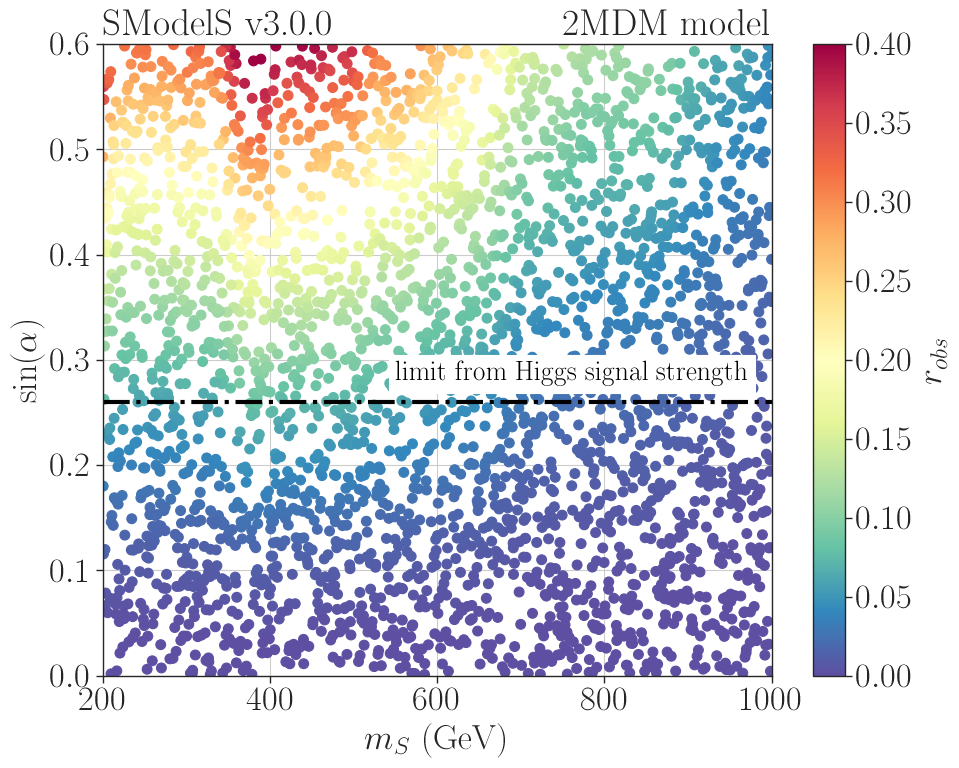

In [48]:
cm = plt.colormaps.get_cmap('Spectral_r')
plt.figure(figsize=(10,8))


x = rbrDF['mS']
y = rbrDF['sina']
c = np.array(rbrDF['ExptRes.result.r']) / np.array(rbrDF['BRs.sd.chi,chi'])

plt.hlines(0.26, 200, 1000, linestyle='dashdot', color='black',linewidth=3.0)
# plt.plot(atlas_curve['mS'], atlas_curve['sinalpha'])

im = plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0., vmax=0.4)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{obs}$', size=25)

#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)

plt.ylim(0,0.6)
plt.xlim(200,1000)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)
    
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 
plt.text(550., 0.28, r'limit from Higgs signal strength', color='black', backgroundcolor='white', fontsize=20)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=27)
plt.title(r'2MDM model', loc='right', fontsize=27)

plt.grid()
plt.tight_layout()
plt.savefig('./figures/2mdm_rs.png')

plt.show()

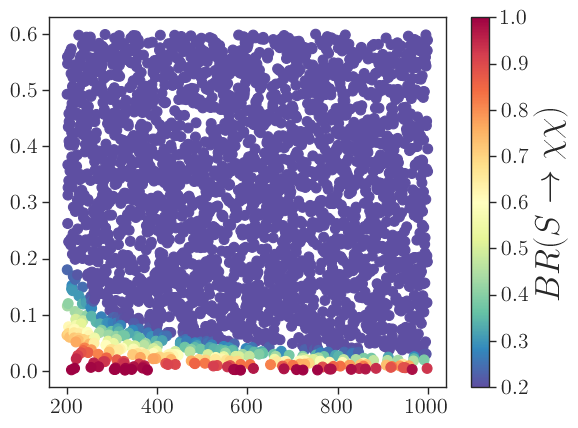

In [44]:

x = rbrDF['mS']
y = rbrDF['sina']
c = rbrDF['BRs.sd.chi,chi']

im = plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.2, vmax=1.0)
cb = plt.colorbar(im)
cb.set_label(label=r'$BR(S \to \chi \chi)$', size=25)

plt.show()